# Multi-Modal Conversational Agent with ReAct Prompting

In this tutorial, we will demonstrate how we can utilize a [7b Llava model](xtuner/llava-llama-3-8b-v1_1-transformers) to perform multi-step reasoning with tools, to answer Open-Domain questions.

To get both images and posts, we will use a [blog post](https://www.domesticatedcompanion.com/facts-about-forrest-gump/28?xcmg=1&_d=d) containing fun facts about the the movie "Forest Gump". We will also include some additional images, to supplement our image data.

This tutorial is based on this [original haystack tutorial](https://haystack.deepset.ai/tutorials/25_customizing_agent).

All assets for this tutorial are available in the [official fastRAG repository](https://github.com/IntelLabs/fastRAG).

In [1]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

First, lets load some multi-modal data:

In [2]:
import json
entries = json.load(open("../assets/multi_modal_files/intel_image_data.json", "r"))

Each entry contains a brief textual description, with a title and an image.

Next, we create an index for the documents above.

Lets proceed to our Document Retrieval Pipeline.
It will consist of a retriever to fetch the inital batch, and a [re-ranker]("cross-encoder/ms-marco-MiniLM-L-6-v2") to return the best one.

In [3]:
document_store = InMemoryDocumentStore()

In [4]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from fastrag.prompt_builders.multi_modal_prompt_builder import MultiModalPromptBuilder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = """{% for document in documents %}
    {{ document.content }}
{% endfor %}"""

rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=1))
rag_pipe.add_component("prompt_builder", MultiModalPromptBuilder(template=template))

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
print(f"LLM pipeline created")

LLM pipeline created


We create our document tool:

In [5]:
from fastrag.agents.tools.tools import DocWithImageTool

To allow our tool to index and query our pipeline, we provide with an ```indexing_function``` and ```query_function```:

In [7]:
def create_pipeline():
    index_pipeline = Pipeline()
    index_pipeline.add_component(
        instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
    )
    return index_pipeline
    

In [8]:
from fastrag.agents.tool_handlers import HaystackQueryHandler, HaystackIndexingHandler
doc_tool = DocWithImageTool(
    name="docRetriever",
    query_handler=HaystackQueryHandler(
        pipeline=rag_pipe,
    ),
    index_handler=HaystackIndexingHandler(
        create_pipeline=create_pipeline,
        document_store=document_store
    ),
    description="useful for when you need to retrieve textual documents to answer questions.",
    output_variable="documents",
)

With document tool ready, we can upload the content:

In [9]:
params = {
    "data_rows": [entries]
}

In [10]:
doc_tool.upload_data_to_pipeline(params)

100%|██████████| 3/3 [00:00<00:00, 34759.43it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Lets test it out:

In [11]:
query = "Where are Intel's headquarters?"
rag_res = doc_tool.run(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
print(rag_res[0])


Success! I have found the image and text I need:

    Headquarters in Santa Clara, California, in 2023

I will now use the image and text to answer the question.



To orchestrate the usage of all our tools, we will also create a tools manager: 

In [13]:
from fastrag.agents.base import ToolsManager

tools_manager=ToolsManager(tools=[doc_tool])

With the tools manager ready, we create our conversational agent.
For more information about the AGENT_PROMPT and resolver functions, we refer to the [original haystack tutorial](https://haystack.deepset.ai/tutorials/25_customizing_agent).

In [14]:
from fastrag.agents.create_agent import AGENT_ROLES

Now we will load our multi-modal generator:

In [15]:
from fastrag.generators.stopping_criteria.stop_words import StopWordsByTextCriteria
from transformers import AutoTokenizer, StoppingCriteriaList

In [16]:
model_name_or_path = "xtuner/llava-llama-3-8b-v1_1-transformers"

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
stop_word_list = ["Observation:", "<|eot_id|>"]

In [19]:
sw = StopWordsByTextCriteria(
    tokenizer=tokenizer, stop_words=stop_word_list, device="cpu"
)

In [20]:
from fastrag.generators.llava import LlavaHFGenerator
import torch

generator = LlavaHFGenerator(
    model = model_name_or_path,
    task = "image-to-text",
    generation_kwargs = {
        "max_new_tokens": 100,
        "stopping_criteria": StoppingCriteriaList([sw])
    },
    huggingface_pipeline_kwargs={
        "torch_dtype": torch.bfloat16
    },
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


With our tools and generator ready, we create our agent:

In [21]:
from fastrag.agents.base import Agent

In [22]:
from fastrag.agents.create_agent import ConversationMemory

In [23]:
conversational_agent = Agent(
    generator,
    prompt_template=AGENT_ROLES,
    tools_manager=tools_manager,
    memory=ConversationMemory(generator=generator),
)

Lets start chatting to our model!

We can start by asking the model a question about an image.

In [24]:
generator.warm_up()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
agent_res = conversational_agent.run("Give me an image of headquarters. What is the color of the building?")


Agent Agent started with {'query': 'Give me an image of headquarters. What is the color of the building?', 'params': None}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Thought: I need to use a tool to get an image of the headquarters.
Tool: docRetriever
Tool Input: {"input": "headquarters"}
Observation:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Observation: 
Success! I have found the image and text I need:

    Headquarters in Santa Clara, California, in 2023

I will now use the image and text to answer the question.

Thought: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The color of the building is blue.<|eot_id|>


Lets look at the image found for us:

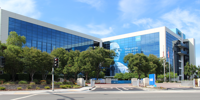

In [26]:
from PIL import Image
import base64
import io

additional_params = conversational_agent.memory.get_additional_params()
image_base64 = additional_params["images"][0]
img = Image.open(io.BytesIO(base64.decodebytes(bytes(image_base64, "utf-8"))))
img.resize((200,100))

The answer seems to be on the money :)

Now, what the model will do if we ask another question about the retrived passage:

In [27]:
agent_res_next = conversational_agent.run("Where is the building located?")


Agent Agent started with {'query': 'Where is the building located?', 'params': None}


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=100) and `max_length`(=32000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The building is located in Santa Clara, California.<|eot_id|>


Correct! The model used the already retrieved passage, no need for additinal retrieval.

Hopefully this gives you an idea of what these types of systems can accomplish, by combining both image and textual data to answer multi-faceted questions. 

Happy coding! :)